## 运行环境
python 3.6.3

Anaconda custom (64-bit)

win10

In [1]:
# _*_ coding:utf-8 _*_
import numpy as np # 矩阵运算
import matplotlib.pyplot as plt #
import NN # 自己实现的神经网络
import importlib # 方便模块修改后重新载入

my Neural Network import succeed


## 任务定义

预测**波斯顿房价**

----------------

## 方法描述 - 非线性拟合

使用**神经网络**进行参数学习

$$
损失函数: \ Lost_i = \frac 1 2 (y^{\{i\}}_p - y^{\{i\}}_r)^2
$$

* $y^{\{i\}}_p$ : 对于第i个样本的预测值(predict), 神经网络的输出
* $y^{\{i\}}_r$ : 第i个样本的真实值(real)

### L2正则化

$$
Cost = \sum _{i=1} ^{m} Lost_i + \frac {\lambda} {2} \sum _ W \Vert {W} \Vert ^2
$$

* $\lambda$ : L2正则化系数, 默认为0.001
* W : 网络层与网络层之间的权重矩阵
* m : 训练样本的数量


-------------------

## 从文件到具体的输入数据

$
文件housing.data \rightarrow X, Y
$

$
X, Y \rightarrow train\_X, train\_Y; test\_X, test\_Y
$

关于X和Y的解释如下

### X, Y

X为所有房子的属性;
每列为单独的一个房子的属性, 有13个数据;

整个矩阵有13行, 506列;
X.shape = (13, 506)

Y为506座房子的价格;
Y.shape = (1, 506)

### train_X, train_Y

训练数据(约占80%)

train_X.shape = (13, 406)

train_Y.shape = (1, 406)

### test_X, test_Y

测试数据(约占20%)

test_X.shape = (13, 100)

test_Y.shape = (1, 100)

In [2]:
# 将类似"2 3.3 4"的字符串转为list[2, 3.4, 4]
def stringLine2numbers(row):
    assert(type(row) == str) # row必须是一个string
    rowSplit = row.split() # 分割为字符串list
    rowFloat = (map(float, rowSplit)) # 将list里的每个string转为float
    return  list(rowFloat)# 返回list

dataPath = "./Housing Data Set/housing.data" # 原始数据的相对路径
dataString = ""
with open(dataPath) as f:
    dataString = f.readlines() # 读入全部行
    
# dataLists[i] 为第i个house相关的数据
dataLists = list(map(stringLine2numbers, dataString))

X = list(map(lambda lis:lis[:-1], dataLists)) # 每行取前13个数值, 即房子的属性
Y = list(map(lambda lis:lis[-1], dataLists)) # 每行取最后1个数值, 即房价

X = np.array(X).reshape(506, 13) # 从list转为numpy的array
Y = np.array(Y).reshape(506, 1) # 从list转为numpy的array



np.random.seed(1) # 打乱X和Y的随机数种子
permutation = np.random.permutation(506) # 这里直接取506了, 因为数据只有506条

train_per = permutation[:406]
train_X = X[train_per,:]
train_Y = Y[train_per,:]


test_per = permutation[406:]
test_X  = X[test_per,:]
test_Y  = Y[test_per,:]

#######################
# 装置并输出shape

X = X.T
Y = Y.T
print("X shape:"+str(X.shape))
print("Y shape:"+str(Y.shape))

train_X = train_X.T
train_Y = train_Y.T
print("train_X shape:"+str(train_X.shape))
print("train_Y shape:"+str(train_Y.shape))

test_X = test_X.T
test_Y = test_Y.T
print("test_X shape:"+str(test_X.shape))
print("test_Y shape:"+str(test_Y.shape))

X shape:(13, 506)
Y shape:(1, 506)
train_X shape:(13, 406)
train_Y shape:(1, 406)
test_X shape:(13, 100)
test_Y shape:(1, 100)


### 初始化网络

#### 网络层数及数量: 下方cell里的代码

#### w和b

$w = randn(L_i, L_{i-1}) \times \sqrt{\frac 2 {L_{i-1}}}$

$b = 0, shape = (L_i, 1)$

* $L_i$ : 第i层网络的节点数量

对应代码为

```python
self.parameters['W'+str(i)] = np.random.randn(layers[i],layers[i-1]) * np.sqrt(2 / layers[i-1])
self.parameters['b'+str(i)] = np.zeros((layers[i],1))
```

#### L2正则化系数$\lambda = 0.001$


#### 不开启dropout


#### 学习率

恒定学习率，但是可以停下来，修改学习率后，继续训练

手动控制学习率和迭代次数

对每次的训练进行多重组合

In [6]:
np.random.seed(1) # 改变随机数种子, 方便复现bug
data = {
'trainX':train_X,
'trainY':train_Y,
'testX':test_X,
'testY':test_Y
}

layers = [13, 100, 50, 13, 1]
print('layers info:',layers)

###################################################

relu = lambda z:np.maximum(0.01 * z,z) # Relu 激活函数
relu_deriv = lambda z,a:np.where(z > 0,1.0,0.01) # Relu 激活函数的导数
sigmoid = lambda z:1/(1+np.exp(-z)) # sigmoid 激活函数
sigmoid_deriv = lambda z,a:np.multiply(a,1-a) # sigmoid 激活函数的导数

def myLostFunc(A, Y):
    assert(A.shape == Y.shape),'A.shape != Y.shape'
    lost = np.square(A - Y) / 2
    return lost

def computeCost(A, Y):
    losts = myLostFunc(A, Y)
    return np.mean(losts)

# 最后一层的输出函数
def mySquare(Z):
    A = Z
    return A

# 最后一层的输出函数的导数
def mySquare_deriv(Z, A, Y):
    assert(A.shape == Y.shape),'A.shape is not same as Y.shape'
    return A - Y

def getFunction(layers): # 初始化function
    function = {
                'activation':{},
                'derivative':{},
                'lostFunction':myLostFunc,
                'predictFunction':lambda A:A,
                'accuracyFunction':computeCost
                }
    L = len(layers) - 1
    for i in range(1,L):
        function['activation'][i] = relu
        function['derivative'][i] = relu_deriv
    function['activation'][L] = mySquare
    function['derivative'][L] = lambda Z,A,Y:mySquare_deriv(Z,A,Y)
    return function

function = getFunction(layers)
importlib.reload(NN) # 重新import模块, 便于修改后重新import
myNN = NN.NN(data, layers, function) # 初始化网络!!!!!!

layers info: [13, 100, 50, 13, 1]
my Neural Network import succeed
L2 regularition: lambda = 0.001
open-dropout: False


### 开始训练

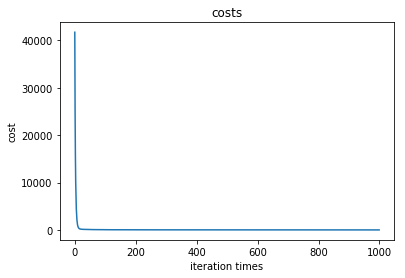

--------------------
train cost: 35.6965690716
test cost: 32.140335305


In [7]:
# batchSize 为 406相当于对全体训练集进行了学习, 因为自己很久之前实现的train函数在使用时出了问题, 
# 暂时找不到bug在哪, 碰巧这个函数没有bug, 所以这里用miniBatchRandom这个函数
# 但是不代表这里使用了mini batch这类方法
costs =  myNN.miniBatchRandom(learningRate=1 * 1e-7, batchSize=406, batchTimes=1000, getCost=True)
# 绘制cost函数曲线

plt.plot(costs)
plt.title('costs')
plt.xlabel("iteration times")
plt.ylabel("cost")
plt.show()

# 显示代价函数的值
print('-'*20)
print('train cost:',myNN.function['accuracyFunction'](myNN.predict(X = train_X),train_Y))
print('test cost:',myNN.function['accuracyFunction'](myNN.predict(X = test_X),test_Y))

## 可视化

对于训练集


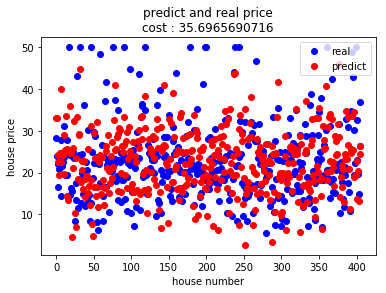

------------------------------
对于测试集


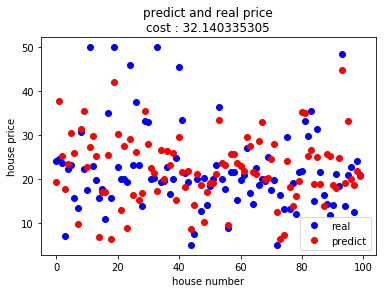

In [8]:
# 可视化模型的效果
# y轴代表房价, 有预测值以及实际值
def my_predict_show(Y_predict, Y_real, cost):
    plt.plot(Y_real, 'bo', label = "real")
    plt.plot(Y_predict, 'ro', label = "predict")
    plt.title("predict and real price\n" + "cost : " + str(cost))
    plt.xlabel("house number")
    plt.ylabel("house price")
    plt.legend()
    plt.show()

print("对于训练集")
my_predict_show(myNN.predict(X = train_X).T, \
                train_Y.T, \
                myNN.function['accuracyFunction'](myNN.predict(X = train_X),train_Y))

print("-"*30)
print("对于测试集")
my_predict_show(myNN.predict(X = test_X).T, \
                test_Y.T, \
                myNN.function['accuracyFunction'](myNN.predict(X = test_X),test_Y))


## 结果分析

### 参数分析

输入层为13

隐层分别为100, 50, 13

输出层为1

L2正则化系数$\lambda = 0.001$

无dropout

每次训练规模为整个训练集

### 训练集测试集分析

train cost: 35.6965690716

test cost: 32.140335305

偏差较小

根据可视化的二维图, 在训练集上, 有不少房价较高的数据没有很好地拟合, 方差较大



